In this notebook, we will expand on the **SSL-ALM** experiments from the [preprint](https://arxiv.org/abs/2507.04033): *Benchmarking Stochastic Approximation Algorithms for Fairness-Constrained Training of Deep Neural Networks*.

Specifically, we will train a classifier DNN on a dataset with a binary sensitive attribute, with a constraint on the absolute difference in loss on samples belonging to those groups.

$$

  \min_{\theta\in R^n} \quad
  \frac{1}{|\mathcal{D}|} \sum_{X_i, Y_i \in \mathcal{D}} \ell( f_\theta(X_i) , Y_i) + \mathcal{R}(\theta) \\
  \\
  \textbf{s.t.} \\
  \\
-\delta \le \frac{1}{|\mathcal{D}[s_1]|} \sum_{X_{i}, Y_{i} \in \mathcal{D}[s_1] }
  \ell( f_\theta(X_i) , Y_i) - \frac{1}{|\mathcal{D}[s_2]|} \sum_{X_{i}, Y_{i} \in \mathcal{D}[s_2]}\ell( f_\theta(X_i) , Y_i) \le \delta

$$

Start by loading and preprocessing the **data**:

In [ ]:
import torch
from folktables import ACSDataSource, generate_categories, ACSIncome
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["OK"], download=True)
definition_df = data_source.get_definitions(download=True)
categories = generate_categories(features=ACSIncome.features, definition_df=definition_df)
df_feat, df_labels, _ = ACSIncome.df_to_pandas(acs_data,categories=categories, dummies=True)

# binarize the RAC1P attribute into "White" and "Non-White"
df_feat['RAC1P_White'] = df_feat['RAC1P_White alone']
df_feat['RAC1P_NonWhite'] = df_feat['RAC1P_White alone'] == False
df_sens = df_feat[['RAC1P_White','RAC1P_NonWhite']].to_numpy(dtype=bool)
df_labels = df_labels.to_numpy()

# remove protected attributes from data
df_feat = df_feat.drop(columns = [c for c in df_feat.columns if c.startswith('RAC1P')]).to_numpy()

# split
X_train, X_test, y_train, y_test, sens_train, sens_test = train_test_split(
    df_feat, df_labels, df_sens, test_size=0.2, random_state=42)
# scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# make into a pytorch dataset
features_train = torch.tensor(X_train, dtype=torch.float32)
labels_train = torch.tensor(y_train,dtype=torch.float32)
sens_train = torch.tensor(sens_train, dtype=torch.bool)
dataset_train = torch.utils.data.TensorDataset(features_train, labels_train)

features_test = torch.tensor(X_test, dtype=torch.float32)
labels_test = torch.tensor(y_test,dtype=torch.float32)
sens_test = torch.tensor(sens_test, dtype=torch.bool)

To make sure that each batch contains representatives of both groups, use ```BalancedBatchSampler``` - a PyTorch-based ```BatchSampler``` that does exactly that.

In [ ]:
from humancompatible.train.fairness.utils import BalancedBatchSampler

dataset = torch.utils.data.TensorDataset(features_train, sens_train, labels_train)

sampler = BalancedBatchSampler(
    subgroup_onehot=sens_train,
    batch_size=64,
    drop_last=True
    )

dataloader = torch.utils.data.DataLoader(dataset, batch_sampler=sampler)

criterion = torch.nn.BCEWithLogitsLoss()

fair_criterion = torch.nn.BCEWithLogitsLoss(reduction='none')
fair_crit_bound = [0.005, 0.005]

Define the **model**:

In [ ]:
from torch.nn import Sequential
hsize1 = 64
hsize2 = 32
model = Sequential(
    torch.nn.Linear(features_train.shape[1], hsize1),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize1, hsize2),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize2, 1)
)

Now, let's set up the **optimizer**.

In theory, the SSL-ALM algorithm requires two independent samples of the constraints to calculate an unbiased estimate of the gradient of the Augmented Lagrangian function (speifically, of the penalty term).

In our experiments, we failed to notice it impacting optimization or generalization performance; however, it does make the code unwieldier.

Let's test it: the ```use_two_constraint_samples``` variable switches between using one or two samples in the training loop. Feel free to run a training loop with and without it!

In [ ]:
from humancompatible.train.algorithms.torch import SSLALM

m = 2

optimizer = SSLALM(
    params=model.parameters(),
    m=m,
    lr=0.005,
    dual_lr=0.01,
    dual_bound=5,
    rho=1.
)

# add slack variables
slack_vars = torch.zeros(m, requires_grad=True)
optimizer.add_param_group(param_group={"params": slack_vars, "name": "slack"})

use_two_constraint_samples = True

epochs = 300

We also do not directly constrain the absolute value of the difference in loss. Instead, we split it into two constraints:
$$
L_1 - L_2 - \delta \leq 0
\\
L_2 - L_1 - \delta \leq 0
$$

In [ ]:
from itertools import combinations
import numpy as np


avg_epoch_loss_log = []
avg_epoch_c_log = []
for epoch in range(epochs):
    loss_log = []
    c_log = []
    for batch_input, batch_sens, batch_label in dataloader:

        # evaluate constraints and constraint grads
        c_vals = []
        c_vals_raw = []
        
        if use_two_constraint_samples:
            c_inputs, c_labels, c_sens = batch_input[::2], batch_label[::2], batch_sens[::2]
        else:
            c_inputs, c_labels, c_sens = batch_input, batch_label, batch_sens
        c_sens_norm = c_sens.div(torch.sum(c_sens, axis=0))

        # calculate loss for each group
        c_loss = fair_criterion(model(c_inputs).squeeze(), c_labels.squeeze()) @ c_sens_norm
        c_val_raw_vec = []
        # in our setup (2 groups) we only have 1 combination
        for (l1, l2) in combinations(c_loss, 2):
            c_val_raw_vec.append(l1-l2)
            c_val_raw_vec.append(l2-l1)

        for i in range(m):
            optimizer.zero_grad()
            c_val = c_val_raw_vec[i] + slack_vars[i] - fair_crit_bound[i]
            # retain_graph in all but last iteration to calculate grads
            c_val.backward(retain_graph = i < m-1)
            # update dual multipliers and save constraint grads
            optimizer.dual_step(i, c_val)
        
            c_vals.append(c_val.detach())
            c_vals_raw.append(c_val_raw_vec[i].detach())

        # use two constraint samples to calculate gradient instead of one
        if use_two_constraint_samples:
            with torch.no_grad():
                c_vals = []
                c_inputs, c_labels, c_sens = batch_input[1::2], batch_label[1::2], batch_sens[1::2]
                c_sens_norm = c_sens.div(torch.sum(c_sens, axis=0))

                # calculate loss for each group
                c_loss = fair_criterion(model(c_inputs).squeeze(), c_labels.squeeze()) @ c_sens_norm
                c_val_raw_vec = []
                # in our setup (2 groups) we only have 1 combination
                for (l1, l2) in combinations(c_loss, 2):
                    c_val_raw_vec.append(l1-l2)
                    c_val_raw_vec.append(l2-l1)

                for i in range(m):
                    c_val = c_val_raw_vec[i] + slack_vars[i] - fair_crit_bound[i]
                    c_vals.append(c_val)

        optimizer.zero_grad()
        # evaluate loss and loss grad
        logits = model(batch_input)
        loss = criterion(logits.squeeze(), batch_label.squeeze()) + torch.zeros_like(slack_vars) @ slack_vars # SLACK
        loss.backward()
                
        optimizer.step(c_vals)
        optimizer.zero_grad()

        # slack variables must be non-negative. this is the "projection" step from the SSL-ALM paper
        with torch.no_grad():
            for s in slack_vars:
                if s < 0:
                    s.zero_()

        loss_log.append(loss.item())
        c_log.append([c.item() for c in c_vals_raw])

    avg_epoch_c_log.append(np.mean(c_log, axis=0))
    avg_epoch_loss_log.append(np.mean(loss_log))
    with np.printoptions(precision=4):
        print(
            f"Epoch: {epoch}, loss: {np.mean(loss_log)}, constraints: {np.mean(c_log, axis=0)}, dual: {optimizer._dual_vars.detach().numpy()}"
        )

Epoch: 0, loss: 0.6914852151745244, constraints: [ 0.0017 -0.0017], dual: [4.8556e-03 8.0899e-06]
Epoch: 1, loss: 0.6462371652586418, constraints: [ 0.0264 -0.0264], dual: [0.0295 0.    ]
Epoch: 2, loss: 0.6186578211031462, constraints: [ 0.0413 -0.0413], dual: [0.0709 0.0003]
Epoch: 3, loss: 0.6019532518428669, constraints: [ 0.0716 -0.0716], dual: [0.1469 0.    ]
Epoch: 4, loss: 0.5876540614847552, constraints: [ 0.0687 -0.0687], dual: [0.2195 0.    ]
Epoch: 5, loss: 0.5793295497434181, constraints: [ 0.0727 -0.0727], dual: [0.2967 0.    ]
Epoch: 6, loss: 0.5748594241184101, constraints: [ 0.0711 -0.0711], dual: [0.3721 0.0008]
Epoch: 7, loss: 0.5708059035895163, constraints: [ 0.0795 -0.0795], dual: [0.4571 0.0044]
Epoch: 8, loss: 0.5645431047468855, constraints: [ 0.0699 -0.0699], dual: [0.531  0.0098]
Epoch: 9, loss: 0.5595027522036904, constraints: [ 0.067 -0.067], dual: [0.6017 0.016 ]
Epoch: 10, loss: 0.5547043024970774, constraints: [ 0.0868 -0.0868], dual: [0.695 0.   ]
Epoch

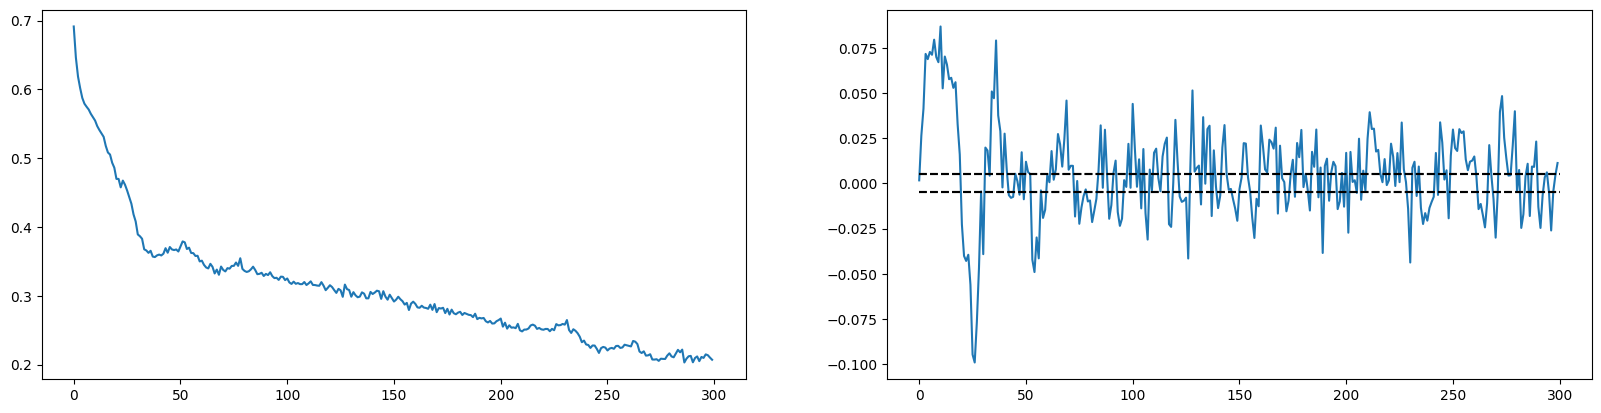

In [ ]:
from matplotlib import pyplot as plt

avg_epoch_c_log = np.array(avg_epoch_c_log)

f, ax = plt.subplots(1,2, sharex='all')
ax[0].plot(avg_epoch_loss_log)
ax[1].plot(avg_epoch_c_log[:,0])
ax[1].hlines((fair_crit_bound, [-1*b for b in fair_crit_bound]), xmin=0, xmax=epochs, color='black', ls='--')

f.set_figwidth(20)

In [ ]:
loss = torch.nn.BCEWithLogitsLoss()

train_samples_w, train_labels_w = features_train[sens_train[:,0]], labels_train[sens_train[:,0]]
train_samples_nw, train_labels_nw = features_train[sens_train[:,1]], labels_train[sens_train[:,1]]

train_logits_w = model(train_samples_w)
train_logits_nw = model(train_samples_nw)

print("Train loss difference:")
print(loss(train_logits_w, train_labels_w) - loss(train_logits_nw, train_labels_nw))


test_samples_w, test_labels_w = features_test[sens_test[:,0]], labels_test[sens_test[:,0]]
test_samples_nw, test_labels_nw = features_test[sens_test[:,1]], labels_test[sens_test[:,1]]

test_logits_w = model(test_samples_w)
test_logits_nw = model(test_samples_nw)

print("Test loss difference:")
print(loss(test_logits_w, test_labels_w) - loss(test_logits_nw, test_labels_nw))

Train loss difference:
tensor(0.0108, grad_fn=<SubBackward0>)
Test loss difference:
tensor(-0.0519, grad_fn=<SubBackward0>)
